<a href="https://colab.research.google.com/github/willewiik/Text-Mining/blob/main/lab2/l2/TM-Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-info">
    
➡️ Before you start, make sure that you are familiar with the **[study guide](https://liu-nlp.ai/text-mining/logistics/)**, in particular the rules around **cheating and plagiarism** (found in the course memo).

➡️ If you use code from external sources (e.g. StackOverflow, ChatGPT, ...) as part of your solutions, don't forget to add a reference to these source(s) (for example as a comment above your code).

➡️ Make sure you fill in all cells that say **`YOUR CODE HERE`** or **YOUR ANSWER HERE**.  You normally shouldn't need to modify any of the other cells.

</div>

# L2: Text Classification

Text classification is the task of sorting text documents into predefined classes. The concrete problem you will be working on in this lab is the classification of speeches with respect to their political affiliation. The specific texts you are going to classify are speeches held in the [Riksdag](https://www.riksdagen.se/en/), the Swedish national legislature.

In [1]:
%matplotlib inline

In [2]:
!git clone https://github.com/willewiik/Text-Mining.git
%cd "Text-Mining/lab2/l2"

Cloning into 'Text-Mining'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 73 (delta 15), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (73/73), 16.74 MiB | 11.38 MiB/s, done.
Resolving deltas: 100% (15/15), done.
/content/Text-Mining/lab2/l2


## Dataset

The raw data for this lab comes from [The Riksdag’s Open Data](https://data.riksdagen.se/in-english/). We have preprocessed and tokenized the speeches and put them into two compressed [JSON](https://en.wikipedia.org/wiki/JSON) files:

* `speeches-201718.json.bz2` (speeches from the 2017/2018 parliamentary session)
* `speeches-201819.json.bz2` (ditto, from the 2018/2019 session)

We start by loading these files into two separate data frames.

In [3]:
import pandas as pd
import bz2

with bz2.open('speeches-201718.json.bz2', mode='rt', encoding='utf-8') as source:
    speeches_201718 = pd.read_json(source, encoding='utf-8')

with bz2.open('speeches-201819.json.bz2', mode='rt', encoding='utf-8') as source:
    speeches_201819 = pd.read_json(source, encoding='utf-8')

When you inspect the two data frames, you can see that there are three labelled columns: `id` (the official speech ID), `words` (the space-separated words of the speech), and `party` (the party of the speaker, represented by its customary abbreviation).

In [4]:
speeches_201718.head()

,id,words,party
0,H5-002-004,eders majestäter eders kungliga högheter herr ...,S
1,H5-003-001,aktuell debatt om situationen för ensamkommand...,V
2,H5-003-002,herr talman och ledamöter jag vill börja med a...,S
3,H5-003-003,herr talman åhörare den här debatten handlar a...,M
4,H5-003-004,herr talman ansvar och rättssäkerhet är två or...,SD


Throughout the lab, we will be using the speeches from **2017/2018** as our **training data**, and the speeches from **2018/2019** as our **test data**.

In [5]:
training_data, test_data = speeches_201718, speeches_201819

For later reference, we store the sorted list of party abbreviations.

In [6]:
parties = sorted(training_data['party'].unique())
print(parties)

['C', 'KD', 'L', 'M', 'MP', 'S', 'SD', 'V']


## Problem 1: Data visualization

Let’s start by getting to know the data better by producing a simple visualization.  More specifically, we ask you to compare the two data frames with respect to the distribution of the speeches over the different parties.

_(If you are not familiar with the Swedish political system and the parties represented in the Riksdag in particular, then we suggest that you have a look at the Wikipedia article about the [2018 Swedish general election](https://en.wikipedia.org/wiki/2018_Swedish_general_election), but it’s not required for solving this lab.  Neither is knowing Swedish!)_

Your task is to **write code to generate two bar plots** that visualize the party distribution, one for the 2017/2018 speeches and one for the 2018/2019 speeches. Inspect the two plots, and compare them

* to each other; and
* to the results of the 2014 and the 2018 general elections.

To facilitate the comparison, you should plot the parties in descending order of their total number of speeches.

**_Note:_** You can produce the bar plots in any way you like (e.g. with Matplotlib, Seaborn, or directly with Pandas); if you don’t know where to start, one suggestion is to look at [seaborn’s tutorial for “visualizing categorical data”](https://seaborn.pydata.org/tutorial/categorical.html), specifically the parts about making _count_ plots.

In [7]:
# Importing seaborn style — usually a good choice by default
import seaborn as sns
sns.set()

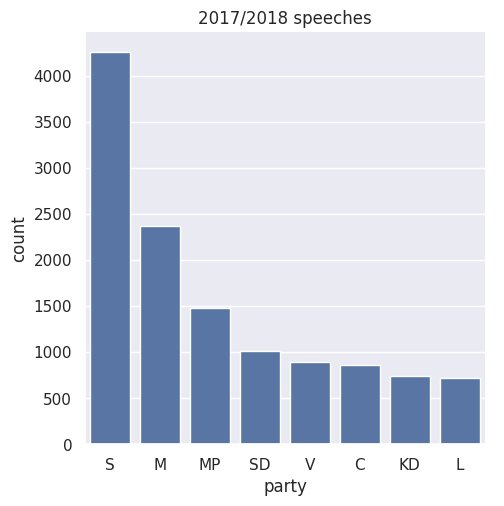

In [23]:
"""Produce a plot for the 2017/2018 speeches."""

party_counts = training_data["party"].value_counts()
g = sns.catplot(data=training_data, x="party", kind="count", order=party_counts.index)
g.set(title = "2017/2018 speeches")



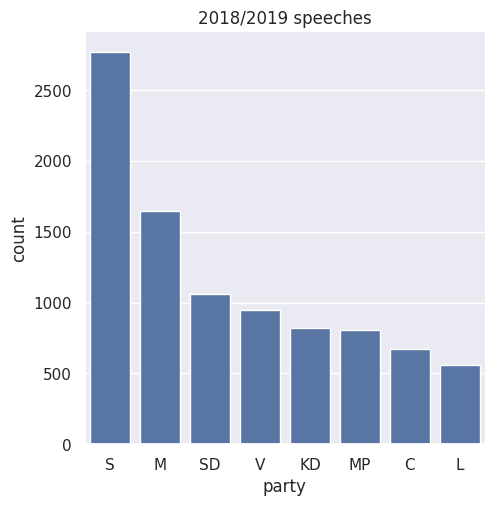

In [27]:
"""Produce a plot for the 2018/2019 speeches."""

party_counts = test_data['party'].value_counts()
g = sns.catplot(data=test_data, x="party", kind="count", order=party_counts.index)
g.set(title = "2018/2019 speeches")


After you made the plots, **summarize your observations** very briefly in the cell below!

In both training and test "S" are the most frequent speakers by a large margin and "M" are the second most frequent speakers. However there are some differences, for example "MP" are the third most frequent speakers in training but sixth most frequent speakers in test. The uneven party frequencies can cause problems when classifying.

## Problem 2: Naive Bayes classifier

You are now ready to train and evaluate a classifier. More specifically, we ask you to train a [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) classifier. You will have to

1. vectorize the speeches in the training data _(with simple token counts)_
2. instantiate and fit the Naive Bayes model on the training data
3. evaluate the model on the test data

You can use any approach you like, but a suggestion is to use scikit-learn’s convenience [Pipeline class](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) that allows you to solve the first two tasks with very compact code. For the evaluation you can use the function [classification_report()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), which will report per-class precision, recall and F1, as well as overall accuracy.

**Write code to produce a Multinomial Naive Bayes classifier as described above and report its performance on the test data!**

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import numpy as np

# 1. Vectorize
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(training_data['words'])
X_test = vectorizer.transform(test_data['words'])

# 2. Naive Bayes
mnb = MultinomialNB()
y_fit = mnb.fit(X_train, training_data['party'])


In [53]:
y_pred = y_fit.predict(X_test)
print(classification_report(test_data['party'], y_pred, zero_division=0))

              precision    recall  f1-score   support

           C       0.00      0.00      0.00       671
          KD       0.00      0.00      0.00       821
           L       0.00      0.00      0.00       560
           M       0.50      0.00      0.00      1644
          MP       0.00      0.00      0.00       809
           S       0.30      1.00      0.46      2773
          SD       0.00      0.00      0.00      1060
           V       0.00      0.00      0.00       950

    accuracy                           0.30      9288
   macro avg       0.10      0.13      0.06      9288
weighted avg       0.18      0.30      0.14      9288



Would you have expected the results that you got? (No need to write anything about this just yet, but make sure you understand what the values in the report mean.)

## Problem 3: Baselines

Evaluation metrics such as accuracy or F1-score should not be understood as _absolute_ measures of performance, but should be used only to _compare_ different classifiers. When other classifiers are not available, there are some simple baselines we can use that are implemented by scikit-learn’s [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html).

One of the simplest baseline is to predict, for every document, that class which appears most often in the training data. This baseline is also called the _most frequent class_ baseline.

**Write code to fit the most-frequent-class baseline on the training data and report its performance on the test data!**

In [55]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
y_fit = dummy_clf.fit(X_train, training_data['party'])

y_pred = y_fit.predict(X_test)
print(classification_report(test_data['party'], y_pred, zero_division=0))

              precision    recall  f1-score   support

           C       0.00      0.00      0.00       671
          KD       0.00      0.00      0.00       821
           L       0.00      0.00      0.00       560
           M       0.00      0.00      0.00      1644
          MP       0.00      0.00      0.00       809
           S       0.30      1.00      0.46      2773
          SD       0.00      0.00      0.00      1060
           V       0.00      0.00      0.00       950

    accuracy                           0.30      9288
   macro avg       0.04      0.12      0.06      9288
weighted avg       0.09      0.30      0.14      9288



A slightly more interesting baseline is a classifier that generates predictions by random sampling, while respecting the training set’s class distribution.  This way of random sampling is sometimes called _stratified sampling_.

**Write code to fit the random sampling baseline on the training data and report its performance on the test data!**

In [56]:
# YOUR CODE HERE
dummy_clf = DummyClassifier(strategy="uniform")
y_fit = dummy_clf.fit(X_train, training_data['party'])

y_pred = y_fit.predict(X_test)
print(classification_report(test_data['party'], y_pred, zero_division=0))

              precision    recall  f1-score   support

           C       0.07      0.11      0.08       671
          KD       0.09      0.14      0.11       821
           L       0.06      0.13      0.08       560
           M       0.17      0.13      0.15      1644
          MP       0.09      0.12      0.10       809
           S       0.31      0.13      0.18      2773
          SD       0.10      0.11      0.11      1060
           V       0.11      0.13      0.12       950

    accuracy                           0.12      9288
   macro avg       0.12      0.12      0.12      9288
weighted avg       0.17      0.12      0.13      9288



## Problem 4: Creating a balanced data set

As you saw in Problem&nbsp;1, the distribution of the speeches over the eight different parties (classes) is imbalanced. One technique used to alleviate this is **undersampling**, in which one randomly removes samples from over-represented classes until all classes are represented with the same number of samples.

Your task here is to **implement undersampling to create a balanced subset of the training data**. Afterwards, **rerun the evaluation** from Problem&nbsp;2 on the balanced data and compare the results.

**_Hint:_** Your balanced subset should consist of 5,752 speeches.

In [79]:
"""Implement undersampling with the classifier from Problem 2 and report its performance on the test data."""

# YOUR CODE HERE
min_n = training_data["party"].value_counts().min()

all_n = training_data["party"].value_counts()
strat_train = []

for party in parties:
  part = training_data[training_data["party"] == party]
  part = part.sample(n=min_n)
  strat_train.append(part)

# adding colnames
strat_train = pd.concat(strat_train)
strat_train.columns = training_data.columns
print(strat_train["party"].value_counts()) # to confirm we got balanced dataset

# Naive Bayes
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(strat_train['words'])
X_test = vectorizer.transform(test_data['words'])
mnb = MultinomialNB()
y_fit = mnb.fit(X_train, strat_train['party'])
y_pred = y_fit.predict(X_test)
print(classification_report(test_data['party'], y_pred, zero_division=0))

party
C     719
KD    719
L     719
M     719
MP    719
S     719
SD    719
V     719
Name: count, dtype: int64
              precision    recall  f1-score   support

           C       0.30      0.41      0.34       671
          KD       0.24      0.44      0.31       821
           L       0.31      0.39      0.35       560
           M       0.36      0.55      0.44      1644
          MP       0.35      0.36      0.35       809
           S       0.83      0.24      0.37      2773
          SD       0.47      0.35      0.40      1060
           V       0.40      0.50      0.44       950

    accuracy                           0.39      9288
   macro avg       0.41      0.41      0.38      9288
weighted avg       0.50      0.39      0.38      9288



## Problem 5: Confusion matrix

A _confusion matrix_ is a type of table that is useful when analysing the performance of a classifier. In this table, both the rows and the columns correspond to classes, and each cell $(i, j)$ states how many times a sample with _gold-standard_ class $i$ was _predicted_ as belonging to class $j$.

In scitkit-learn, a simple way to visualize the confusion matrix as a _heatmap_ is to use [ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html).  The following cell demonstrates how to compute and display a confusion matrix for the classifier in the `model` variable — you may have to adjust this based on the code you have written for your previous solutions:

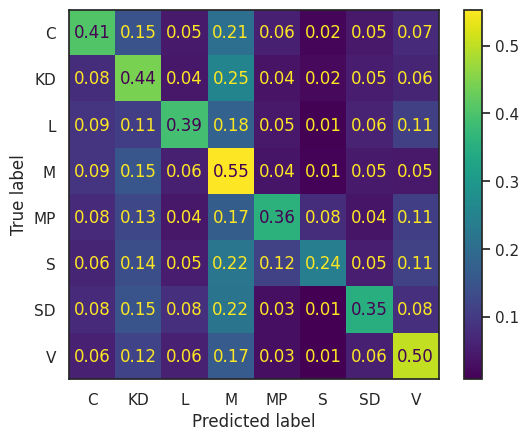

In [96]:
from sklearn.metrics import ConfusionMatrixDisplay

with sns.axes_style("white"):  # Seaborn’s default style doesn’t play well with ConfusionMatrixDisplay, so we change it temporarily
    ConfusionMatrixDisplay.from_estimator(
        mnb,                 # The model that you want to plot the confusion matrix for
        X_test,    # The input data for the model
        test_data['party'],    # The correct (gold-standard) labels for the input data
        normalize='true',
        values_format='.2f'
    )

**Your task** is to use the confusion matrix in order to find, for each given party $p$ in the Riksdag, that other party $p'$ which the classifier that you trained in Problem&nbsp;4 most often confuses with $p$ when it predicts the party of a speaker.  You can read this off of the visualization above, but for the purposes of this exercise, we want to do this programmatically (i.e. with code).  For this, you most likely want to use the scikit-learn function [confusion_matrix()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), which gives you the confusion matrix of a classifier.

**Write code that, for each party $p$, print the party most often confused with $p$ by the classifier from Problem 4!**

In [100]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(test_data['party'], y_pred)


for i in range(len(parties)):
  row = conf_mat[i]
  off_diag = row.copy()
  off_diag[i] = 0 # Setting the i:th value to zero, the party cant be most confused with itself
  party_max = off_diag.argmax() # index of highest value
  print(f"{parties[i]} is most often confused with {parties[party_max]}")


C is most often confused with M
KD is most often confused with M
L is most often confused with M
M is most often confused with KD
MP is most often confused with M
S is most often confused with M
SD is most often confused with M
V is most often confused with M


Before you move on, take a minute to reflect on whether your results make sense.

## Problem 6: Grid Search

Until now, you have been using the count-based vectorizer and the Naive Bayes classifier with their default hyperparameters. When working with real-world applications, you would want to find a combination of input representation, model, and hyperparameters that maximizes the performance for the task at hand.

Manually trying out many combinations of hyperparameters of a vectorizer–classifier pipeline can be cumbersome. However, scikit-learn provides functionality for [performing **grid search**](https://scikit-learn.org/stable/modules/grid_search.html), which is the name for an exhaustive search for the best hyperparameters over a _grid_ of possible values.

When searching for the best hyperparameters, it’s important to _not_ run evaluations on the final test set.  Instead, one should either use a separate validation set, or run cross-validation over different folds. Here we will use cross-validation, which scikit-learn provides in the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class.  To use grid search, you need to know which parameters can be tuned and what they’re called; you can find this information by calling `get_params()` on your model pipeline:

In [102]:
# Replace "nb_pipe" with the variable that has your model pipeline, if necessary
mnb.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}

Your task is to **find a pipeline that outperforms the model from Problem&nbsp;4** on _at least one_ of the aggregated evaluation metrics (accuracy, macro avg., or weighted avg. scores) on the test set, by performing **grid search with 5-fold cross-validation** on the training set.  Which hyperparameters you tune and what values you choose is up to you, as long as try at least _two different hyperparameters_ with at least _two different values_ each, and your resulting pipelines outperforms the one from Problem&nbsp;4.  However, here are some suggestions:

* In the vectorizer, you could try a _set-of-words_ (binary) model in addition to the default _bag-of-words_ model.
* In the vectorizer, you could try extracting bigrams and/or trigrams in addition to unigrams.
* In the Naive Bayes classifier, you could try to using different values for additive smoothing.

**Write code to perform grid search, then report the results of your best model, along with the parameter values that yielded these results.**

In [119]:
# YOUR CODE HERE
from sklearn.model_selection import GridSearchCV
import warnings

# Suppress RuntimeWarnings for divide by zero encountered in log
warnings.filterwarnings("ignore", category=RuntimeWarning)

best_acc = []
for i in (1,2):
  vectorizer = TfidfVectorizer(ngram_range = (1,i))
  X_train = vectorizer.fit_transform(strat_train['words'])
  X_test = vectorizer.transform(test_data['words'])
  mnb = MultinomialNB()
  param_grid = {'alpha':np.linspace(0, 2, num = 21)} # Testing 21 different alpha value between 0 and 2
  search = GridSearchCV(mnb, param_grid, cv = 5, scoring='accuracy')
  search.fit(X_train, strat_train['party'])
  print(f"Best alpha for ngram = {i} is {search.best_params_} with accuracy = {search.best_score_}")




Best alpha for ngram = 1 is {'alpha': 0.1} with accuracy = 0.580147168813508
Best alpha for ngram = 2 is {'alpha': 0.1} with accuracy = 0.6143947418124126


## Individual reflection

<div class="alert alert-info">
    <strong>After you have solved the lab,</strong> write a <em>brief</em> reflection (max. one A4 page) on the question(s) below.  Remember:
    <ul>
        <li>You are encouraged to discuss this part with your lab partner, but you should each write up your reflection <strong>individually</strong>.</li>
        <li><strong>Do not put your answers in the notebook</strong>; upload them in the separate submission opportunity for the reflections on Lisam.</li>
    </ul>
</div>

In this lab, you have produced evaluation reports for a total of five classifiers:

- two baselines (most frequent class & random sampling)
- Naive Bayes with default values and unbalanced data
- Naive Bayes with default values and undersampled data
- the best-performing pipeline from your grid search

How do you interpret these evaluation reports, i.e., what do they mean for the usefulness of each classifier? What conclusion do you draw from these results? Refer to specific evaluation scores that you find particularly relevant for your argument.

**Congratulations on finishing this lab! 👍**

<div class="alert alert-info">
    
➡️ Before you submit, **make sure the notebook can be run from start to finish** without errors.  For this, _restart the kernel_ and _run all cells_ from top to bottom. In Jupyter Notebook version 7 or higher, you can do this via "Run$\rightarrow$Restart Kernel and Run All Cells..." in the menu (or the "⏩" button in the toolbar).

</div>